In [1]:
library('tidyverse')
library("hise")
library('data.table')
library('parallel')
library('dplyr')
library(patchwork)
library(ggplot2)
library(arrow)
library(Seurat)

set.seed(123)

Sys.setenv( TZ="Etc/GMT+1")
options(warn = -1)

Warning message:
“package ‘tidyverse’ was built under R version 4.3.3”
Warning message:
“package ‘tibble’ was built under R version 4.3.3”
Warning message:
“package ‘tidyr’ was built under R version 4.3.3”
Warning message:
“package ‘readr’ was built under R version 4.3.3”
Warning message:
“package ‘purrr’ was built under R version 4.3.3”
Warning message:
“package ‘dplyr’ was built under R version 4.3.3”
Warning message:
“package ‘stringr’ was built under R version 4.3.3”
Warning message:
“package ‘forcats’ was built under R version 4.3.3”
Warning message:
“package ‘lubridate’ was built under R version 4.3.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()

In [2]:
adata<-anndata::read_h5ad("/home//workspace/IHA_Review_Analysis/Other_Analysis/06_TEAseq_Day0/TEA_scRNA_all.h5ad")

In [3]:
pbmc<-CreateSeuratObject(t(adata$X), project = "SeuratProject", assay = "RNA",
  min.cells = 0, min.features = 0, names.field = 1,
  names.delim = "_", meta.data = adata$obs)

In [4]:
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)

Normalizing layer: counts



# Pseudo Time 1

In [5]:
pesudo_time_df<-as.data.frame(read_parquet('pesudo_time_df.csv'))
pesudo_time_df<-pesudo_time_df[!is.na(pesudo_time_df$AIFI_L3),]
pesudo_time_df <- pesudo_time_df %>%
  mutate(cohort.x = case_when(
    startsWith(subject_id.ch1, "BR2") ~ "BR2",
    TRUE ~ 'UP1' 
  ))

## RNA

In [6]:
dense_matrix <- as.matrix(pbmc@assays$RNA$data[c("LEF1", "TCF7", "ITGB1","GZMK","GZMB", "GZMA", "GZMH"),])
df <- as.data.frame(dense_matrix)

In [7]:
df_scRNA<-as.data.frame(t(df))
df_scRNA$barcodes_scRNA<-rownames(df_scRNA)

In [8]:
pesudo_time_df<-left_join(pesudo_time_df,df_scRNA,by=c("X.x"="barcodes_scRNA"))

In [9]:
subset_data <- pesudo_time_df[sample(nrow(pesudo_time_df), size = 10000), ]  %>% filter(grepl("1",curve.assignments))

In [44]:
matched_cols<-c("GZMK","GZMB", "GZMA", "GZMH" )


In [45]:
p_list <- list()
for (i in matched_cols ) {
  
  p <- ggplot(subset_data, aes(pesudo_time_2, !!as.name(i), color = Age_Group)) +
    geom_smooth(method = "loess", aes(group = Age_Group, color = Age_Group), se = FALSE)
  
  smoothed_data <- ggplot_build(p)$data[[1]]
  
  smoothed_A <- smoothed_data[smoothed_data$colour == '#F8766D', c("x", "y")]
  smoothed_B <- smoothed_data[smoothed_data$colour == '#00BFC4', c("x", "y")]
  
  merged_data <- cbind(smoothed_A, smoothed_B)    
  colnames(merged_data) <- c("x.A", "y.A", "x.B", "y.B")
  merged_data$diff <- merged_data$y.B - merged_data$y.A  
  
  y_limit <- max(abs(range(merged_data$diff)))
  
  is_last <- i == tail(matched_cols, 1)
  
  p_list[[i]] <- ggplot(merged_data, aes(x = x.A, y = diff)) +
  geom_area(data = subset(merged_data, diff >= 0), fill = "#bf812d", alpha = 0.8) +
  geom_area(data = subset(merged_data, diff <= 0), fill = "#35978f", alpha = 0.8) +
  geom_line(color = "black", size = 0.1) +
  geom_hline(yintercept = 0, color = "black") +
  labs(
    y = NULL,  
    x = if (is_last) "pesudo_time" else NULL
  ) +
  theme_linedraw() +
  theme(
    axis.title.x = if (is_last) element_text() else element_blank(),
    axis.text.x = if (is_last) element_text() else element_blank(),
    axis.ticks.x = if (is_last) element_line() else element_blank(),
    axis.title.y = element_blank(),
    axis.title.y.right = element_text(size = 10, angle = 90), 
    axis.text.y.right = element_blank(), 
    axis.ticks.y.right = element_blank() 
  ) +
  scale_y_continuous(limits = c(-0.8, 0.8),
    sec.axis = sec_axis(~., name = i)
  ) +
  theme(plot.margin = margin(0, 0, 0, -1.2, "cm")) +
  xlim(0, 22)

}

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


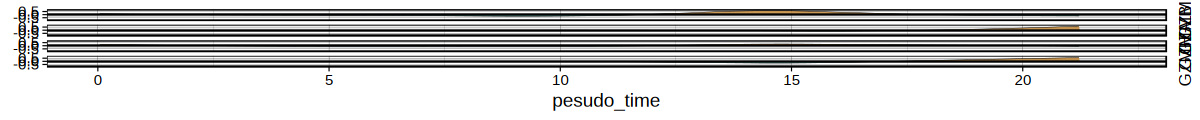

In [46]:
options(repr.plot.width = 10, repr.plot.height =1)

p_combined<-wrap_plots(p_list,ncol=1)+ 
  plot_layout(guides = "collect")
p_combined

In [47]:
summary_range<-subset_data %>% group_by(AIFI_L3) %>% summarize(
  max_range = quantile(pesudo_time_2, 0.95),
  min_range = quantile(pesudo_time_2, 0.05)
)

In [48]:
options(repr.plot.width = 12, repr.plot.height =2)

p1<-ggplot(
  summary_range %>% mutate(celltype_new = fct_reorder(AIFI_L3, min_range)), 
  aes(x = celltype_new)
)+  geom_linerange(aes(ymin = min_range, ymax = max_range), linetype = 1, color = "black") +
  geom_point(aes(y = min_range), size = 3, color = "red") +
  geom_point(aes(y = max_range), size = 3, color = "red") +
  theme_bw() +
  coord_flip()+xlab("")+ylab("")+
    theme(
      axis.title.x =  element_blank(),
      axis.text.x =  element_blank(),
      axis.ticks.x =  element_blank()
    ) +ylim(0,22)


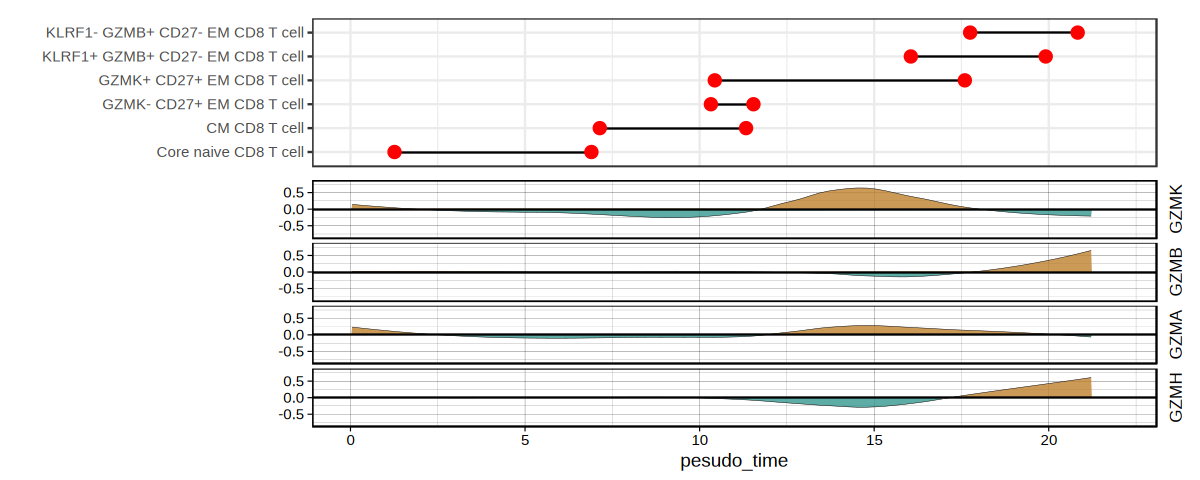

In [52]:
options(repr.plot.width = 10, repr.plot.height =4)

p1 / p_combined+ plot_layout(heights = c(0.15, 0.25))
